# BCycle Austin models

This notebook concludes the BCycle Austin series of blog posts, and looks at how machine learning could be used to help the BCycle team. I'll be using weather data in addition to the station and bike information, and building models which I hope might be useful. Let's get started !

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

import datetime

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading and cleaning weather data

I used [Weather Underground](https://www.wunderground.com/history/airport/KATT/2016/4/1/CustomHistory.html?dayend=3 1&monthend=5&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1) to download a CSV with daily weather information from Austin's Camp Mabry station (KATT). This includes the following data fields:

* Date
* Min, mean, and max:
  * Temperature (degrees Fahreinheit)
  * Dew Point (degrees Fahreinheit)
  * Humidity (%)
  * Sea Level Pressure (inches)
  * Visibility (miles)
  * Wind speed (mph)
* Max gust (mph)
* Precipitation (inches)
* Events (combinations of Fog, Rain, Thunderstorm)

The `load_weather` function includes a lot of cleaning and pre-processing to get the raw CSV into a good state for the rest of the analysis.

In [2]:
weather_df = load_weather()
weather_df.head(6)

,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,rain,thunderstorm,fog
date,,,,,,,,,,,,,,
2016-04-01,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,True,True,False
2016-04-02,74,45,76,23,30.32,30.18,13,5,20,0.00,0.0,False,False,False
2016-04-03,79,44,89,27,30.26,30.08,12,3,17,0.00,0.0,False,False,False
2016-04-04,83,53,66,30,30.21,30.10,12,4,18,0.00,0.0,False,False,False
2016-04-05,82,53,66,33,30.22,30.03,15,5,25,0.00,0.0,False,False,False
2016-04-06,82,55,90,21,30.12,29.93,15,6,23,0.00,37.5,False,False,False


In [3]:
weather_df.describe()

,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,81.901639,62.360656,90.721311,53.475410,30.045246,29.867213,13.737705,5.295082,22.770492,0.235410,55.532787
std,5.682443,7.122810,8.374826,17.527699,0.121197,0.134872,3.224395,1.676745,5.643266,0.424349,34.348442
min,66.000000,44.000000,66.000000,15.000000,29.760000,29.540000,8.000000,2.000000,13.000000,0.000000,0.000000
25%,78.000000,58.000000,87.000000,40.000000,29.980000,29.780000,12.000000,4.000000,19.000000,0.000000,37.500000
50%,83.000000,63.000000,93.000000,56.000000,30.070000,29.900000,14.000000,5.000000,22.000000,0.010000,62.500000
75%,87.000000,67.000000,97.000000,67.000000,30.120000,29.960000,16.000000,7.000000,26.000000,0.310000,87.500000
max,91.000000,77.000000,100.000000,84.000000,30.320000,30.180000,21.000000,9.000000,37.000000,2.250000,100.000000


The summary above shows descriptive statistics for each of the numeric columns in the table. There is a good range of weather conditions in there, including:

* Min and max temperatures ranging from 44°F to 91°F.
* Wind speeds ranging from 2MPH to 21MPH, with individual gusts up to 37MPH !
* Maximum precipitation of 2.25 inches.
* Weather events including fog, thunderstorms, and rain (these aren't included in the summary statistics above).

This should give a good distribution of data to work from. But we have a wide mix of units in each column (MPH, °F, percentages, and weather conditions), so we may have to use some feature normalization to give good results later on.

# Visualizing weather in April/May 2016

Now we have the weather information in a convenient dataframe, we can make some plots to visualize the conditions during April and May. 

## Temperature plots

Let's see how the minimum and maximum temperatures varied.

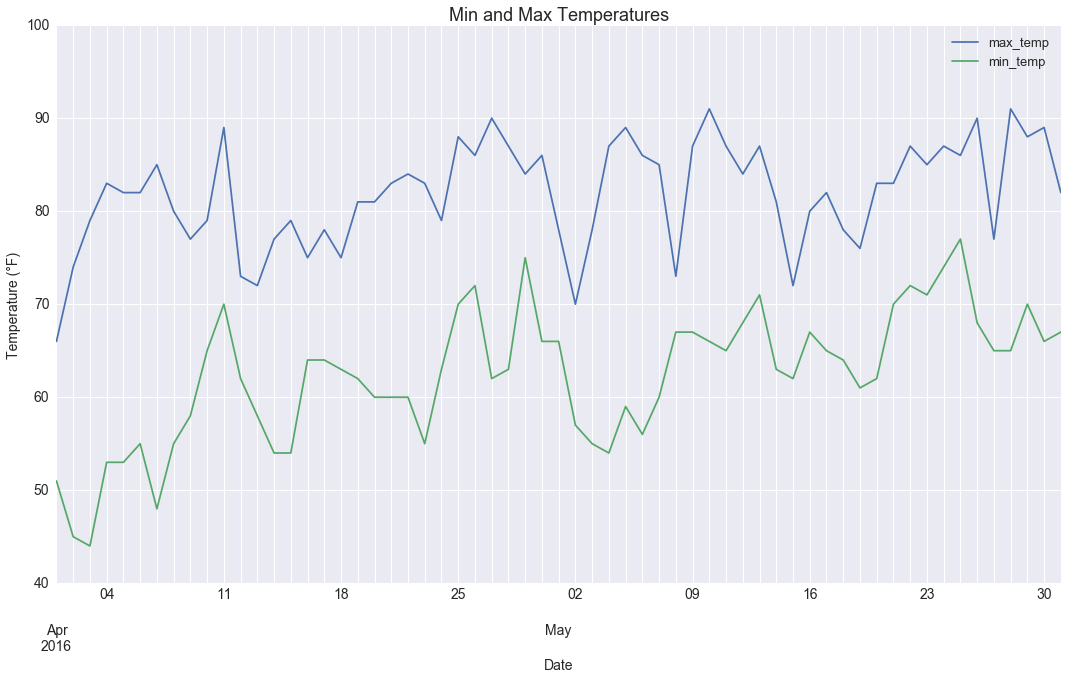

In [4]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df.plot(y=['max_temp', 'min_temp'], ax=ax)
ax.legend(fontsize=13)
xtick = pd.date_range( start=weather_df.index.min( ), end=weather_df.index.max( ), freq='D' )
ax.set_xticks( xtick )
# ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Temperature (°F)', fontdict={'size' : 14})
ax.set_title('Min and Max Temperatures', fontdict={'size' : 18}) 
# fig.autofmt_xdate(rotation=90)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The plot above shows the trends in minimum and maximum temperature during April and May 2016. The overall trend is an increase in both min and max temperatures, with a lot of variation in the changes in temperature. For example, around the 2nd May, the maximum temperature was less than the minimum temperature a few days earlier!

## Temperature distributions

Now we have an idea of how the temperature changed over time, we can check the distribution of min and max temperatures. Some of the models we'll be using expect features to be normally distributed, so we may need to transform the values if they aren't.

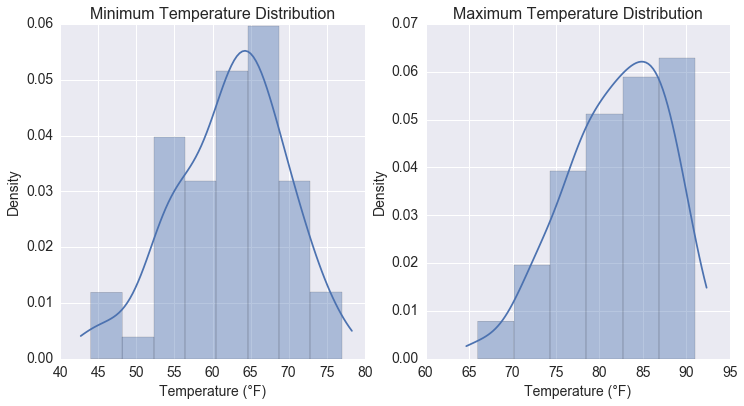

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

# ax[0] = weather_df['min_temp'].plot.hist(ax=ax[0]) # sns.distplot(weather_df['min_temp'], ax=ax[0])
# ax[1] = weather_df['max_temp'].plot.hist(ax=ax[1]) # sns.distplot(weather_df['max_temp'], ax=ax[1])

ax[0] = sns.distplot(weather_df['min_temp'], ax=ax[0])
ax[1] = sns.distplot(weather_df['max_temp'], ax=ax[1])

for axis in ax:
    axis.set_xlabel('Temperature (°F)', fontdict={'size' : 14})
    axis.set_ylabel('Density', fontdict={'size' : 14})

ax[0].set_title('Minimum Temperature Distribution', fontdict={'size' : 16}) 
ax[1].set_title('Maximum Temperature Distribution', fontdict={'size' : 16}) 

## Temperature pair plots

To see how the temperatures are correlated, let's use a pairplot.

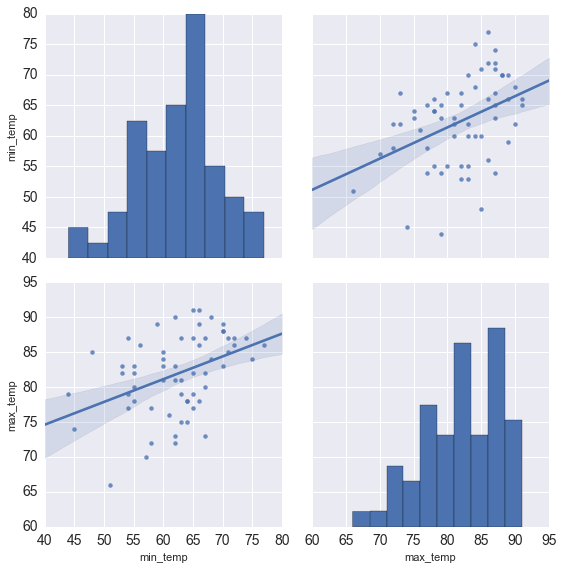

In [6]:
g = sns.pairplot(data=weather_df[['min_temp', 'max_temp']], kind='reg',size=4)

The pair plots show there's a reasonable correlation between the maximum and minimum temperatures.

## Pressure

Let's check the pressure difference in April and May. We don't perceive pressure as directly as temperature, precipitation, or thunderstorms. But there may be some interesting trends.

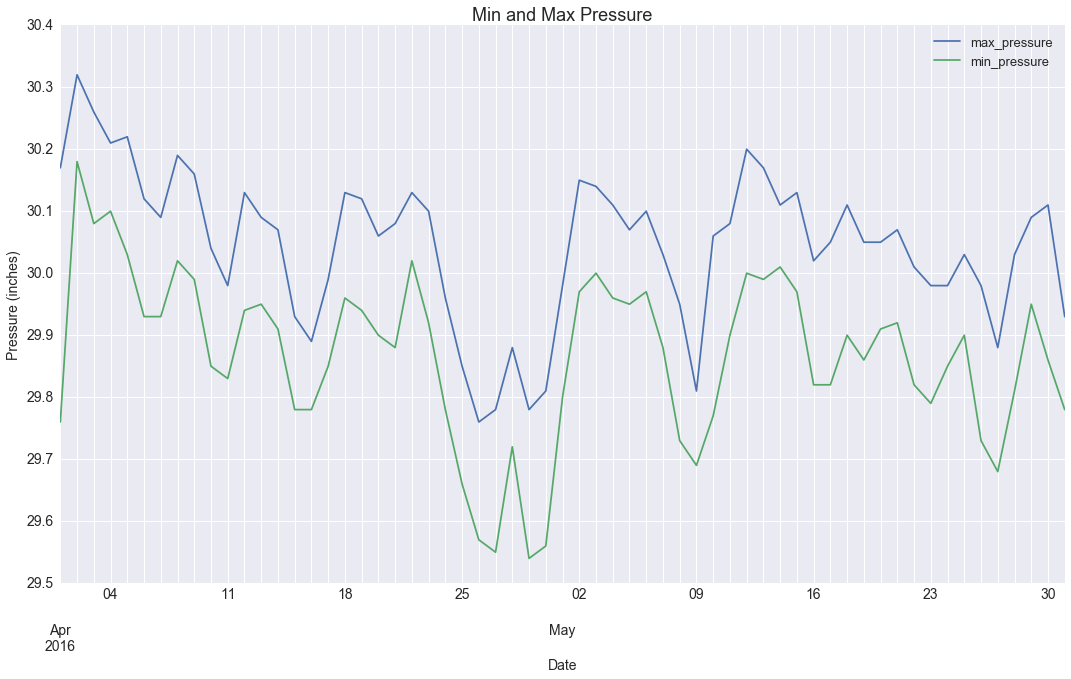

In [7]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df.plot(y=['max_pressure', 'min_pressure'], ax=ax)
ax.legend(fontsize=13)
xtick = pd.date_range( start=weather_df.index.min( ), end=weather_df.index.max( ), freq='D' )
ax.set_xticks( xtick )
# ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Pressure (inches)', fontdict={'size' : 14})
ax.set_title('Min and Max Pressure', fontdict={'size' : 18}) 
# fig.autofmt_xdate(rotation=90)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The plot shows both the max and min pressure as being highly correlated. There may also be correlations between the pressure and other more directly observable factors such as temperature and wind. 

## Precipitation

Let's take a look at the precipitation, to see how much it rained during the data collection phase. 

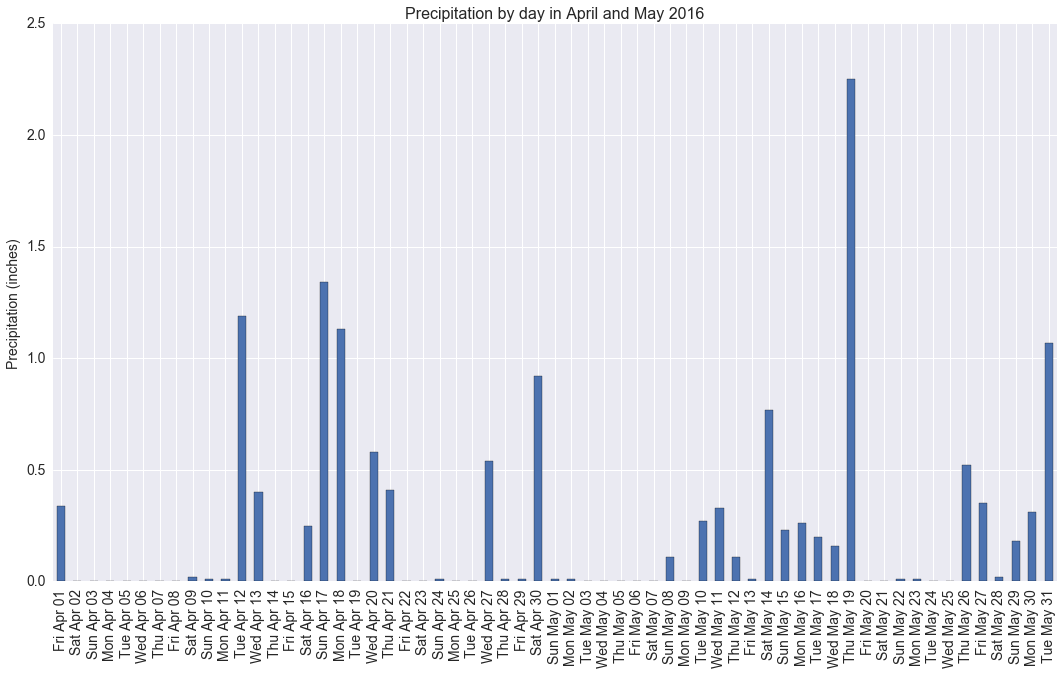

In [8]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df['precipitation'].plot.bar(ax=ax, legend=None)
ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('Precipitation (inches)', fontdict={'size' : 14})
ax.set_title('Precipitation by day in April and May 2016', fontdict={'size' : 16})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The graph shows there was some serious rain in April and May. As well as some dry spells through early April and May, there were also individual days where over an inch of rain fell. I'd definitely not be tempted to take a bike ride in those conditions !

## Precipitation histogram

To see how the distribution of rainfall looks, let's plot out the histogram and Kernel Density Estimate below. Based on the daily plot above, you can see there will likely be a very right skewed distribution with a long tail. For this reason, I'll use the pandas histogram directly, instead of fitting a Kernel Density Estimate.

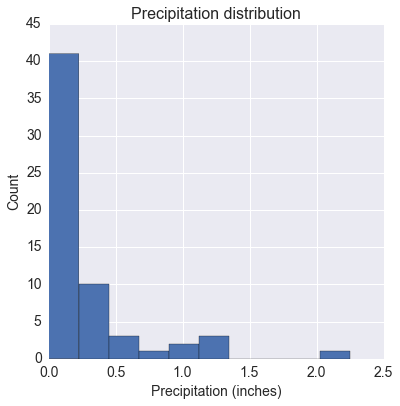

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax = weather_df['precipitation'].plot.hist(ax=ax)
ax.set_xlabel('Precipitation (inches)', fontdict={'size' : 14})
ax.set_ylabel('Count', fontdict={'size' : 14})
ax.set_title('Precipitation distribution', fontdict={'size' : 16}) 


This plot shows the majority of days had no rainfall at all. There were about 10 days with less than 0.5" of rain, and the count of days drops off steeply as the rainfall value increases. We may be able to transform this one-sided skewed distribution by setting a threshold, and converting to a boolean (above / below the threshold).

## Windspeed

The windspeed is likely to play a role in the amount of bike rentals too. I've plotted the minimum, maximum, and gust speeds in the line graph below.

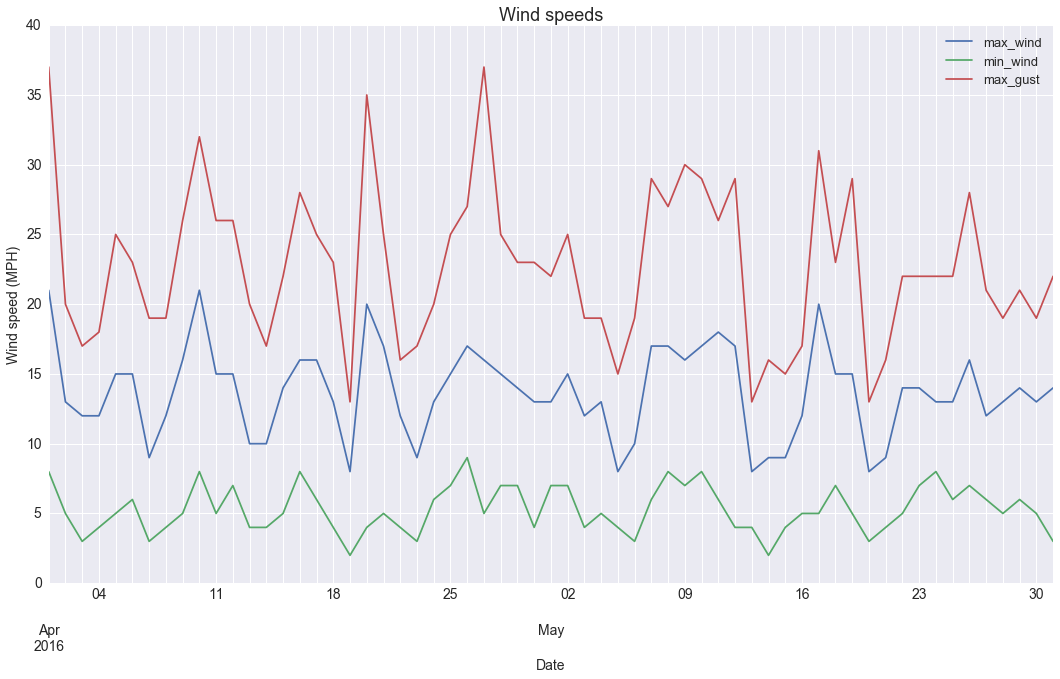

In [10]:
fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = weather_df.plot(y=['max_wind', 'min_wind', 'max_gust'], ax=ax)
ax.legend(fontsize=13)
xtick = pd.date_range( start=weather_df.index.min( ), end=weather_df.index.max( ), freq='D' )
ax.set_xticks( xtick )
# ax.set_xticklabels(weather_df.index.strftime('%a %b %d'))
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Wind speed (MPH)', fontdict={'size' : 14})
ax.set_title('Wind speeds', fontdict={'size' : 18}) 
# fig.autofmt_xdate(rotation=90)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The graph shows a close correlation between the `min_wind`, `max_wind`, and `max_gust` speeds, as you'd expect. When building linear models, it's best to remove highly correlated values so we may just use the `max_gust` of the three based on how correlated they are.

## Wind speed distributions

As I suspect the wind speeds are very correlated, let's use a pairplot to see the correlations as well as individual distributions.

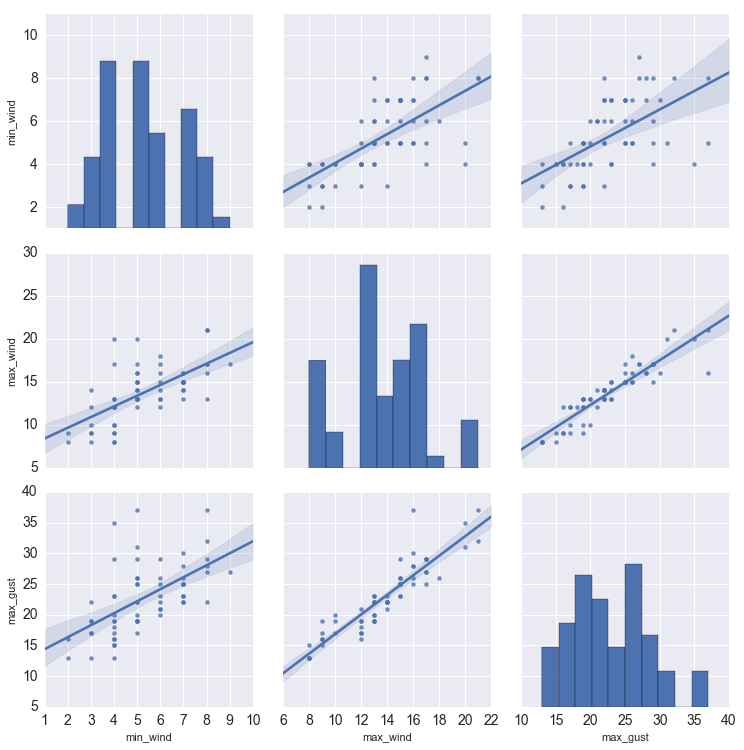

In [11]:
g = sns.pairplot(data=weather_df[['min_wind', 'max_wind', 'max_gust']], kind='reg',size=3.5)

This pairplot shows a high positive correlation between the `max_wind` and `max_gust`, as you'd expect. There is also a strong correlation between the minimum and maximum wind speeds. When building models, we probably need to take the `max_wind` or `max_gust` to avoid multiple correlated columns.

## Weather events

As well as the numeric weather values, there are 3 dummy variables for the events on each day. These are `thunderstorm`, `rain`, and `fog`. Let's plot these below.

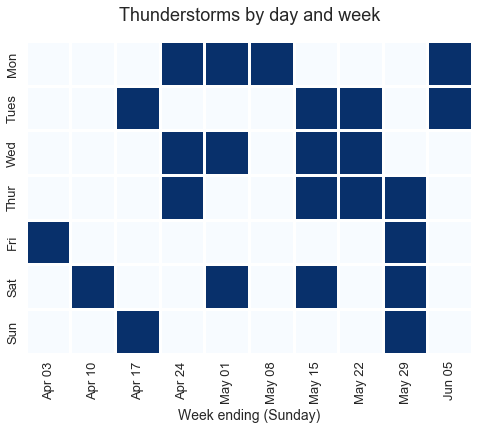

In [12]:
# weather_df[['thunderstorm', 'rain', 'fog']].plot.bar(figsize=(20,20))
heatmap_df = weather_df.copy()
heatmap_df = heatmap_df[['thunderstorm', 'rain', 'fog']]
heatmap_df = heatmap_df.reset_index()
heatmap_df['day'] = heatmap_df['date'].dt.dayofweek
heatmap_df['week'] = heatmap_df['date'].dt.week
heatmap_df = heatmap_df.pivot_table(values='thunderstorm', index='day', columns='week')
heatmap_df = heatmap_df.fillna(False)
# ['day'] = heatmap_df.index.dt.dayofweek

# Restore proper day and week-of-month labels. 
heatmap_df.index = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
weeks = heatmap_df.columns
weeks = ['2016-W' + str(week) for week in weeks] # Convert to '2016-Wxx'
weeks = [datetime.datetime.strptime(d + '-0', "%Y-W%W-%w").strftime('%b %d') for d in weeks]
heatmap_df.columns = weeks

fig, ax = plt.subplots(1,1, figsize=(8, 6))
sns.heatmap(data=heatmap_df, square=True, cmap='Blues', linewidth=2, cbar=False, linecolor='white', ax=ax)
ax.set_title('Thunderstorms by day and week', fontdict={'size' : 18})
ttl = ax.title
ttl.set_position([.5, 1.05])
ax.set_xlabel('Week ending (Sunday)', fontdict={'size' : 14})
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

The heatmap above shows which days had thunderstorms with the dark blue squares. Light blue squares are either days outside of April or May, or those in April and May which had thunderstorms. The plot shows there were more thunderstorms in May, where there were contiguous days of thunderstorms from 3 to 4 days long.

# Modelling bike rentals by day

In this section, I'll be using machine learning to predict how many bike rentals there are in each day. As this is a time series problem, I'll split the dataset as follows. This gives roughly a 70% training - 30% validation data split.

* Training: 1st April to 15th May (6 complete weeks of data).
* Validation: 16th May to 31st May (2 complete weeks of data).

I'll create a couple of simple baselines first, which just use previous rental numbers directly. If our machine learning models can't beat this, there's a problem! After that, I'll use time-series forecasting, and then linear regression.

In [13]:
# First create a daily rentals dataframe, split it into training and validation
rentals_df = load_daily_rentals()
train_df = rentals_df['2016-04-01':'2016-05-15']
val_df = rentals_df['2016-05-16':'2016-05-31']

print('\nTraining data head:\n{}'.format(train_df.head()))
print('\nValidation data head:\n{}'.format(val_df.head()))


Training data head:
            rentals
date               
2016-04-01    353.0
2016-04-02    853.0
2016-04-03    818.0
2016-04-04    525.0
2016-04-05    563.0

Validation data head:
            rentals
date               
2016-05-16    503.0
2016-05-17    405.0
2016-05-18    540.0
2016-05-19    273.0
2016-05-20    847.0


# Baseline - predict daily checkouts using median

To start off with, let's just predict the median amount of checkouts, and see how the RMSE looks.

In [14]:
median_df = train_df.copy()
median = median_df['rentals'].median()

median_pred_df = val_df.copy()
median_pred_df['predicted'] = median

median_pred_df.head()

,rentals,predicted
date,,
2016-05-16,503.0,501.0
2016-05-17,405.0,501.0
2016-05-18,540.0,501.0
2016-05-19,273.0,501.0
2016-05-20,847.0,501.0


## Helper functions

Let's define some helper functions, which are used in the code below. We'll be running these steps multiple times for each model, so it saves copying and pasting.

In [15]:
def RMSE(pred, true):
    '''
    Calculates Root-Mean-Square-Error using predicted and true
    columns of pandas dataframe
    INPUT: pred and true pandas columns
    RETURNS: float of RMSE
    '''
    rmse = np.sqrt(np.sum((pred - true).apply(np.square)) / pred.shape[0])
    return rmse

median_rmse = RMSE(median_pred_df['predicted'], median_pred_df['rentals'])

Median baseline RMSE: 275.72


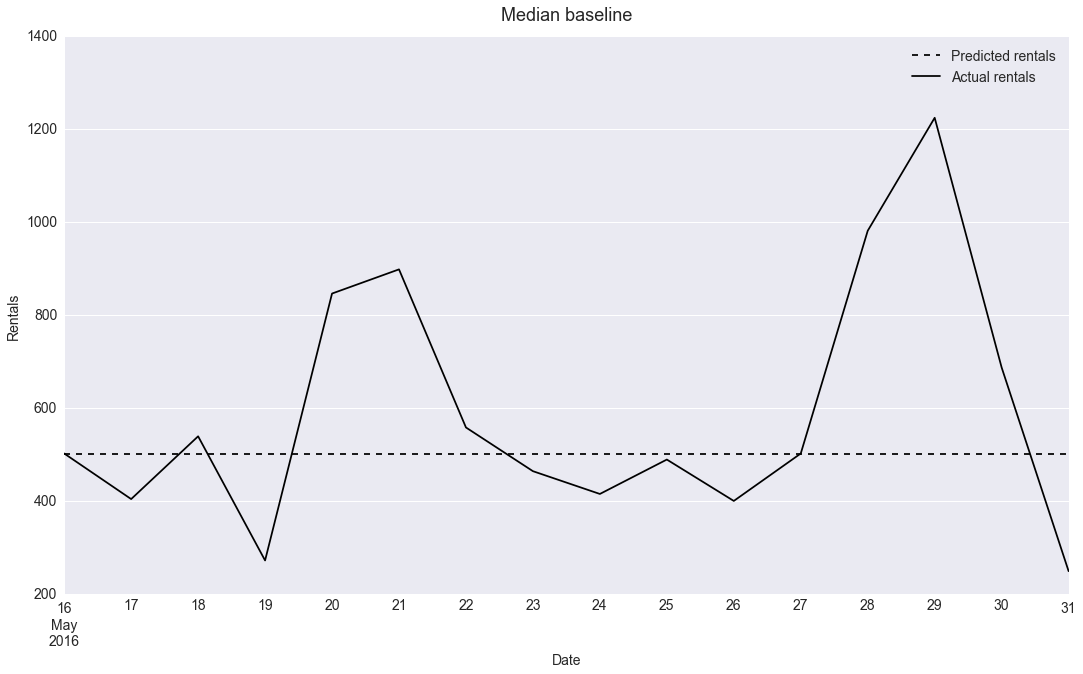

In [16]:
def plot_prediction(df, pred_col, true_col, title):
    '''
    Plots the predicted rentals along with actual rentals for the dataframe
    INPUT: df - pandas dataframe containing predicted and true columns
           pred_col - string with prediction column name
           true_col - string with actual column name
    RETURNS: Nothing
    '''
    fig, ax = plt.subplots(1,1, figsize=(18,10))
    ax = df.plot(y=[pred_col, true_col], ax=ax, color='black', style=['--', '-'])
    ax.set_xlabel('Date', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
#     ax.set_xticklabels(df.index.strftime('%a %b %d'))

scores = dict() # Store the model scores in here
scores['median'] = median_rmse

print('Median baseline RMSE: {:.2f}'.format(median_rmse))
plot_prediction(median_pred_df, 'predicted', 'rentals', title='Median baseline')

By predicting the median amount of rentals for each day, we end up with an RMSE of 276. This means on average in each of the days we're 275 bikes off the actual rental amount. You can see on the plot the static line doesn't track the daily variations in rentals. What if we take the median for each day independently ..?

# Baseline - predict daily rentals using median for day-of-week

To improve on the previous fixed median baseline, we can calculate the median rentals for each day separately in the training set. Then for the days in the test set just use that median value for the prediction. This is a simplistic approach which assumes that every day has similar amounts of rentals.

In [17]:
# Calculate the median amount of checkouts by day of week from the training data
dow_df = train_df.copy()
dow_df = dow_df.reset_index()
dow_df['dayofweek'] = dow_df['date'].dt.dayofweek
dow_df = dow_df.groupby('dayofweek').median().reset_index()
dow_df

,dayofweek,rentals
0,0,488.0
1,1,455.5
2,2,451.0
3,3,481.0
4,4,671.0
5,5,853.0
6,6,669.0


In [18]:
# Use the day-of-week to join the predictions into the validation set, and calculate difference
dow_pred_df = val_df.copy()
dow_pred_df = dow_pred_df.reset_index()
dow_pred_df['dayofweek'] = dow_pred_df['date'].dt.dayofweek
dow_pred_df = pd.merge(dow_pred_df, dow_df, on='dayofweek', how='left', suffixes=('_true', '_pred'))
dow_pred_df['diff'] = dow_pred_df['rentals_pred'] - dow_pred_df['rentals_true']
dow_pred_df.index = dow_pred_df['date']
dow_pred_df = dow_pred_df.drop(['date', 'dayofweek'], axis=1)
dow_pred_df.head()

,rentals_true,rentals_pred,diff
date,,,
2016-05-16,503.0,488.0,-15.0
2016-05-17,405.0,455.5,50.5
2016-05-18,540.0,451.0,-89.0
2016-05-19,273.0,481.0,208.0
2016-05-20,847.0,671.0,-176.0


Now we have predictions for each of the days in the validation set, we can calculate our error metric (Root-Mean-Square-Error) and plot our predictions to see how we did with the simplistic baseline.

Day-of-week median baseline RMSE: 184.63


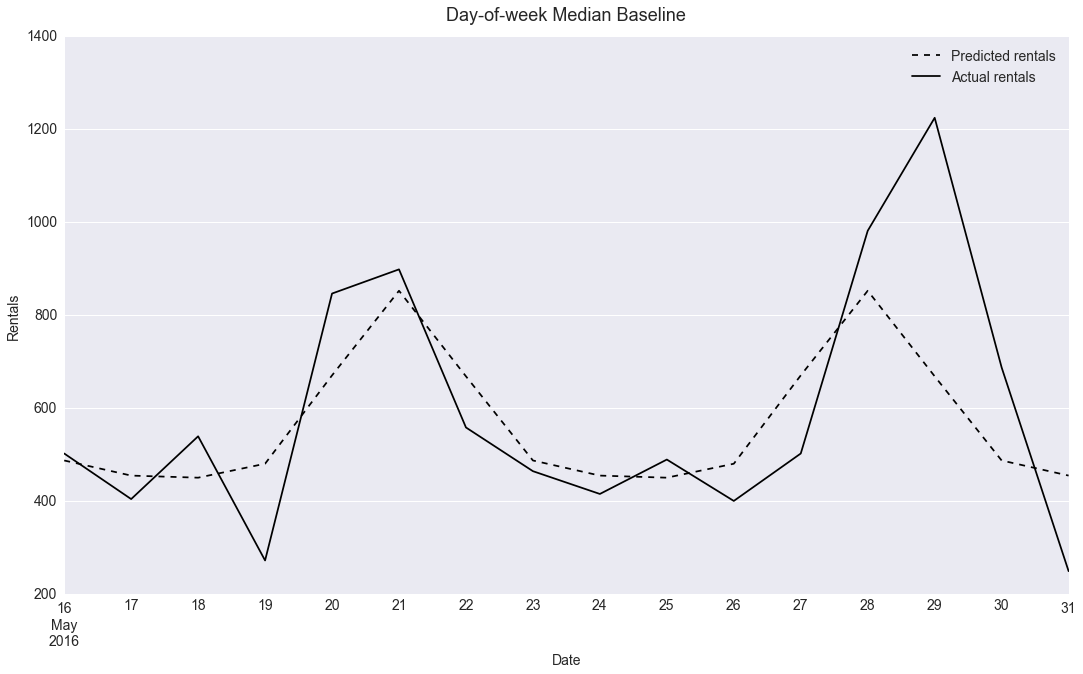

In [19]:
# Calculate the RMSE
pred = dow_pred_df['rentals_pred']
true = dow_pred_df['rentals_true']
dow_rmse = np.sqrt(np.sum((pred - true).apply(np.square)) / pred.shape[0])

scores['dow_median'] = dow_rmse
print('Day-of-week median baseline RMSE: {:.2f}'.format(dow_rmse))
plot_prediction(dow_pred_df, 'rentals_pred', 'rentals_true', title='Day-of-week Median Baseline')

The RMSE for the baseline prediction is 185. This shows that each day, we're off by an average of 185 bikes using this simple benchmark. The plot shows the prediction is actually not far off before the 28th May, which is the Memorial Day weekend. On the 29th May alone, our baseline is off by 550 rentals though.

# Linear models - Time

Now we have some baselines to compare against, let's use a [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) model to predict the daily rentals in the last couple of weeks of the validation dataset. We'll be using the excellent [scikit-learn](http://scikit-learn.org/stable/) library, which has a wide range of [linear models](http://scikit-learn.org/stable/modules/linear_model.html) we can use. First of all, let's do some manipulation on the pandas datasets for model training and validation.

In [20]:
from sklearn import preprocessing

# First let's add some features to help the model out
def add_date_features(input_df):
    '''Adds day-of-week, weekend, and lagged rentals
    INPUT: Dataframe with datetime index
    RETURNS: Copy of dataframe with extra features
    '''
    df = input_df.copy()
    df = df.reset_index()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekend'] = df['dayofweek'] < 5
    df['prev_rentals'] = df['rentals'].shift(+1)
    df.loc[0, 'prev_rentals'] = df.loc[0, 'rentals']
    return df

def reg_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    # Split target and features
    X = np.hstack((df[['weekend', 'prev_rentals']].values, dayofweek))
    y = df['rentals'].values

    return X, y

In [21]:
# Create new time-based features, numpy arrays to train model
reg_train_df = add_date_features(train_df)
reg_val_df = add_date_features(val_df)

X_train, y_train = reg_x_y_split(reg_train_df)
X_val, y_val = reg_x_y_split(reg_val_df)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (45, 9), y_train shape: (45,)
X_val shape: (16, 9), y_val shape: (16,)


In [23]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['reg_train_rmse'] = reg_train_rmse
scores['reg_val_rmse'] = reg_val_rmse

print('Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

Regression RMSE - Train: 131.71, Val: 205.92


In [25]:
def df_from_results(index_train, y_train, y_train_pred, index_val, y_val, y_val_pred):
    
    train_dict = dict()
    val_dict = dict()

    train_dict['true'] = y_train
    train_dict['pred'] = y_train_pred

    val_dict['true'] = y_val
    val_dict['pred'] = y_val_pred

    train_df = pd.DataFrame(train_dict)
    val_df = pd.DataFrame(val_dict)

    train_df.index = index_train
    val_df.index = index_val
    
    return train_df, val_df
    
reg_result_train_df, reg_result_val_df = df_from_results(reg_train_df['date'], y_train, y_train_pred,
                                                         reg_val_df['date'], y_val, y_val_pred)
 

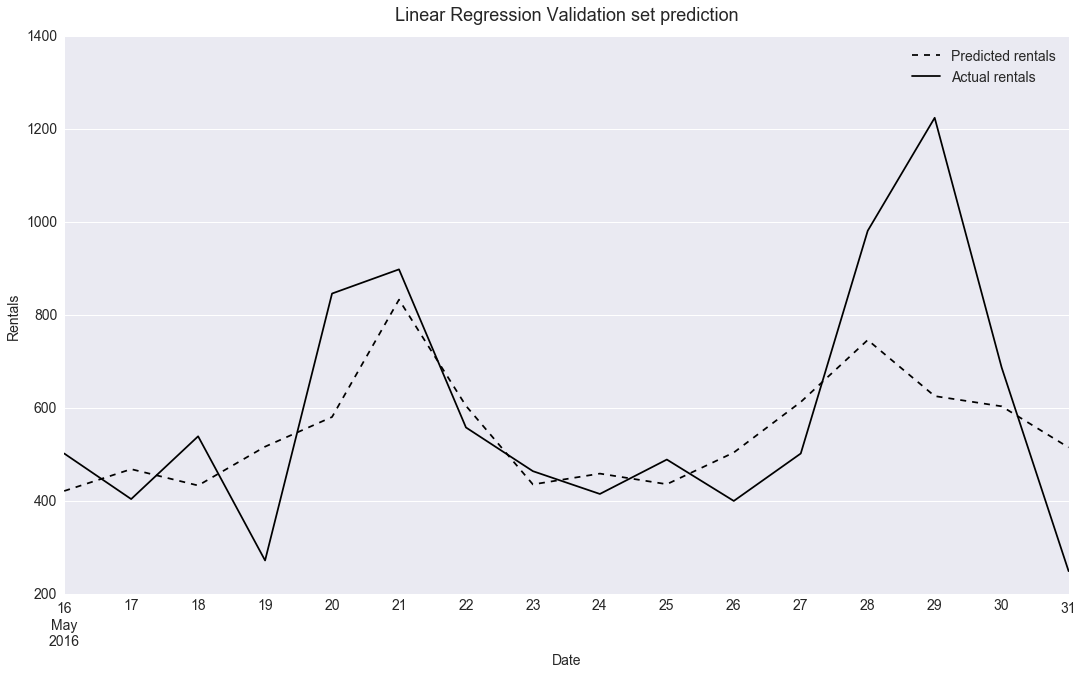

In [26]:
# plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression Validation set prediction')

# Linear Models - Time and Weather

To improve on the previous results, we can use the weather conditions to give the model extra information. First of all, we can do a naive approach and merge in all weather data to see how this changes the performance of the model.

In [68]:
train_weather_df = pd.merge(train_df, weather_df, left_index=True, right_index=True)
val_weather_df = pd.merge(val_df, weather_df, left_index=True, right_index=True)

train_weather_df = add_date_features(train_weather_df)
val_weather_df = add_date_features(val_weather_df)

train_weather_df = train_weather_df.drop('date', axis=1)
val_weather_df = val_weather_df.drop('date', axis=1)

In [69]:
def reg_weather_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    df_index = df.columns[0]
    df = df.reset_index()
    df.drop(df_index, axis=1)
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    # Split target and features
    X = np.hstack((df.drop('rentals', axis=1).values, dayofweek))
    y = df['rentals'].values

    return X, y

X_train, y_train = reg_weather_x_y_split(train_weather_df)
X_val, y_val = reg_weather_x_y_split(val_weather_df)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (45, 25), y_train shape: (45,)
X_val shape: (16, 25), y_val shape: (16,)


In [71]:
train_weather_df.head()

,rentals,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,rain,thunderstorm,fog,dayofweek,weekend,prev_rentals
0,353.0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,True,True,False,4,True,353.0
1,853.0,74,45,76,23,30.32,30.18,13,5,20,0.00,0.0,False,False,False,5,False,353.0
2,818.0,79,44,89,27,30.26,30.08,12,3,17,0.00,0.0,False,False,False,6,False,853.0
3,525.0,83,53,66,30,30.21,30.10,12,4,18,0.00,0.0,False,False,False,0,True,818.0
4,563.0,82,53,66,33,30.22,30.03,15,5,25,0.00,0.0,False,False,False,1,True,525.0


In [73]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['weather_reg_train_rmse'] = reg_train_rmse
scores['weather_reg_val_rmse'] = reg_val_rmse

print('Weather Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

Weather Regression RMSE - Train: 89.60, Val: 205.85


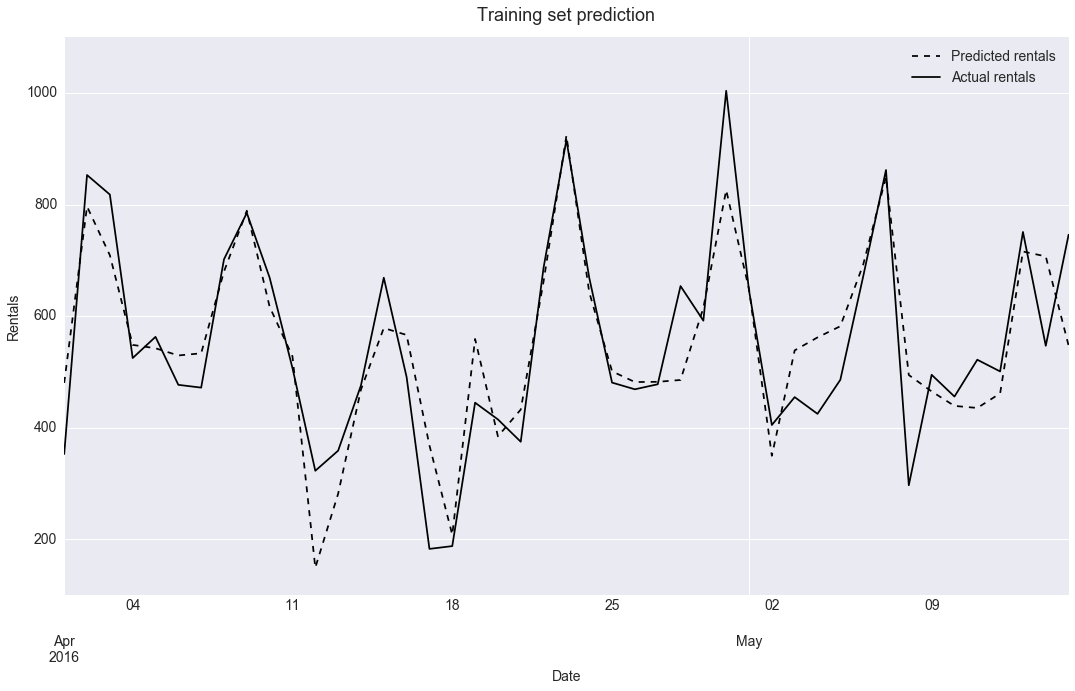

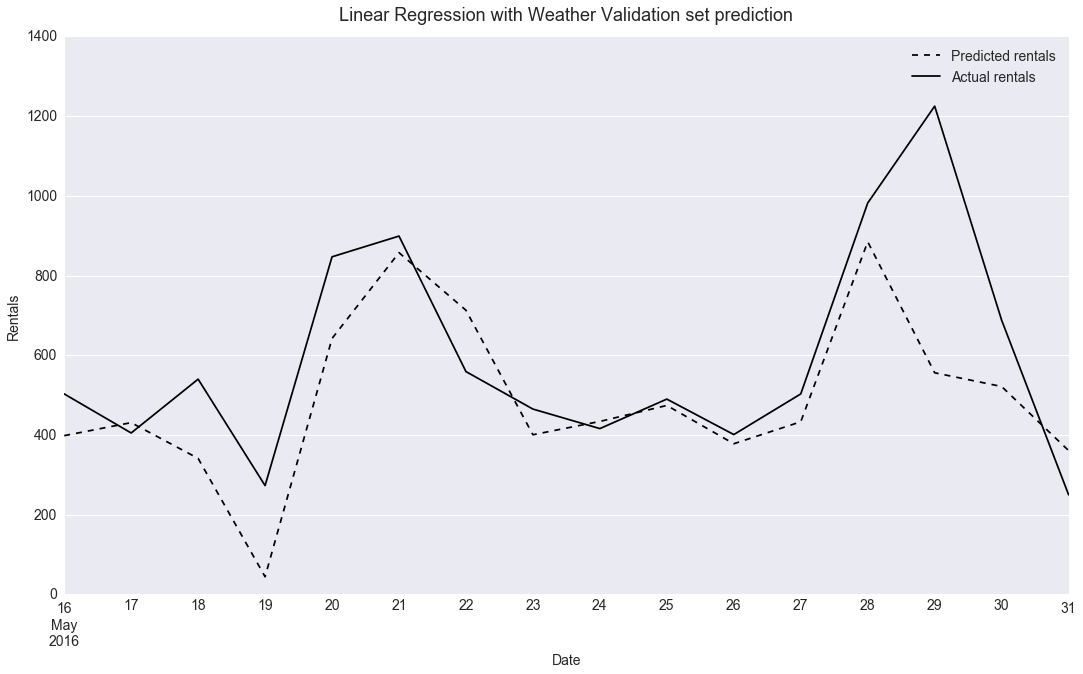

In [79]:
reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')

# Linear Models - Time and Weather with Feature Engineering

The results of the linear models with time and weather show a case of overfitting. The training set RMSE is 90 which is better than all other models so far. But the validation set shows a much worse RMSE of 205. This is worse than the baseline day-of-week median model !

Before addressing the overfitting, we need to remove features which are highly correlated with each other. 

In [80]:
train_weather_df

,rentals,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,rain,thunderstorm,fog,dayofweek,weekend,prev_rentals
0,353.0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,True,True,False,4,True,353.0
1,853.0,74,45,76,23,30.32,30.18,13,5,20,0.00,0.0,False,False,False,5,False,353.0
2,818.0,79,44,89,27,30.26,30.08,12,3,17,0.00,0.0,False,False,False,6,False,853.0
3,525.0,83,53,66,30,30.21,30.10,12,4,18,0.00,0.0,False,False,False,0,True,818.0
4,563.0,82,53,66,33,30.22,30.03,15,5,25,0.00,0.0,False,False,False,1,True,525.0
5,477.0,82,55,90,21,30.12,29.93,15,6,23,0.00,37.5,False,False,False,2,True,563.0
6,472.0,85,48,86,23,30.09,29.93,9,3,19,0.00,0.0,False,False,False,3,True,477.0
7,702.0,80,55,77,25,30.19,30.02,12,4,19,0.00,0.0,False,False,False,4,True,472.0
8,785.0,77,58,84,41,30.16,29.99,16,5,26,0.02,50.0,True,True,False,5,False,702.0
9,669.0,79,65,87,62,30.04,29.85,21,8,32,0.01,100.0,False,False,False,6,False,785.0
